In [41]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import time
import shutil

import warnings
import intake
import pathlib
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
from fastjmd95 import rho
import fastjmd95
assert fastjmd95.__version__ >= "0.2.1"

from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

from fastprogress.fastprogress import progress_bar

from xarrayutils.file_handling import (
    write,
    maybe_create_folder,
    file_exist_check,
    temp_write_split,
)
from xarrayutils.utils import (
    remove_bottom_values,
    mask_mixedlayer
)
from cmip6_preprocessing.preprocessing import (
    combined_preprocessing
)
from cmip6_preprocessing.drift_removal import (
    remove_trend,
    match_and_remove_trend
)
from cmip6_preprocessing.utils import (
    cmip6_dataset_id
)

from cmip6_preprocessing.postprocessing import (
    combine_datasets,
    match_metrics,
    merge_variables
)

import sys
sys.path.append("../../")
from cmip6_omz.upstream_stash import (
    xgcm_transform_wrapper as transform_wrapper,
    match_and_detrend
)
from cmip6_omz.omz_tools import (
    volume_consistency_checks,
    omz_thickness,  
)

from cmip6_omz.utils import (
    cmip6_collection,
)



#still depending on parallel repo for a few things here,
#all of these only show up in the last step

#from aguadv_omz_busecke_2021.utils import print_html
from aguadv_omz_busecke_2021.preprocessing import (
    save_and_reload_rechunker,
    strip_encoding,
)
from aguadv_omz_busecke_2021.omz_tools import (
    plot_omz_results,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Develop functions here

In [3]:
#This could go upstream in a more general form
## but for now let's keep it here and readable
def transform_wrapper_again(
    ds_in,
    intensive_vars=[
        "thetao",
        "o2",
        "so",
        "agessc",
    ],
):

    #sigma_bins = np.array([0, 24.5, 26.5, 27.65, 100])
    sigma_bins = np.array([0, 23.0, 24.5, 25.5, 26.5, 26.65, 26.7, 27.4, 27.65, 27.8, 100])
    # define variables to be averaged (intensive quantities)
    intensive_vars = [
        "thetao",
        "o2",
        "so",
        "agessc",
    ]  # add 'uo', 'agessc' etc?

    intensive_vars = [v for v in intensive_vars if v in ds_in.data_vars]

    for iv in intensive_vars:
        dz = (xr.ones_like(ds_in[iv]) * ds_in.dz_t).where(~np.isnan(ds_in[iv]))
        ds_in[iv] = ds_in[iv] * dz

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ds_out = transform_wrapper(
            ds_in,
            extensive_vars=["omz_thickness"] + intensive_vars,
            target=sigma_bins,
        )

    # reconvert the same variables
    dz = ds_out.dz_t
    for iv in intensive_vars:
        ds_out[iv] = ds_out[iv] / dz
    return ds_out

In [87]:
#this function should go to upstream_stash
def load_trend_dict(verbose = False):
    
    path_jb = '/tigress/GEOCLIM/LRGROUP/jbusecke/projects/aguadv_omz_busecke_2021/data/processed/linear_regression_time_zarr_multimember'
    trendfolder = pathlib.Path(path_jb)
    trend_models = np.unique([ds.attrs['source_id'] for ds in ds_dict.values()])
    flist = []
    for tm in trend_models:
        flist = flist + list(trendfolder.glob(f'*{tm}*_trend.nc'))
    
    total = len(flist)
    progress = progress_bar(range(total))
    
    trend_dict = {}
    for i,path in enumerate(flist):
        key = path.stem
        ds = xr.open_mfdataset([path])
        # write the filename in the dataset
        ds.attrs.update({'filepath':str(path)})
        # exclude all nan slopes (why are these there in the first place?)
        if not np.isnan(ds.slope).all():
            trend_dict[key] = ds
        else:
            if verbose:
                print(f"found all nan regression data for {path}")
        progress.update(i)
    progress.update(total)
    
    return trend_dict


#These are fixes so that the trend data works with cmip6_pp match_and_remove_trend
#these issues should be addressed in the next iteration of trend file production
def fix_trend_metadata(trend_dict):
    for name, ds in trend_dict.items():
        #restore attributes to trend datasets using file names
        fn = (ds.attrs['filepath']).rsplit("/")[-1]
        fn_parse = fn.split('_')
        ds.attrs['source_id'] = fn_parse[2]
        ds.attrs['grid_label'] = fn_parse[5]
        ds.attrs['experiment_id'] = fn_parse[3]
        ds.attrs['table_id'] = fn_parse[4]
        ds.attrs['variant_label'] = fn_parse[7]
        ds.attrs['variable_id'] = fn_parse[8]
        
        #rename 'slope' variable to variable_id
        if "slope" in ds.variables:
            ds = ds.rename({"slope":ds.attrs["variable_id"]})
        
        #error was triggered in line 350 of cmip6_preprocessing.drift_removal
        ##this is a temporary workaround, and the one part of this function that might
        ##require an upstream fix (though it might just be an environment issue)
        ds = ds.drop('trend_time_range')
        
        trend_dict[name] = ds
        
    return trend_dict

In [4]:
def resample_yearly(ds_in, freq="1AS"):
    # this drops some coordinates, so i need to convert them to data_vars and then reconvert
    time_coords = [
        co
        for co in list(ds_in.coords)
        if "time" in ds_in[co].dims and co not in ["time", "time_bounds"]
    ]
    #ds_out = ds_in.reset_coords(time_coords).resample(time=freq).mean()
    ds_out = ds_in.reset_coords(time_coords).coarsen(time=12).mean()
    ds_out = ds_out.assign_coords({co: ds_out[co] for co in time_coords})
    ds_out.attrs.update({k: v for k, v in ds_in.attrs.items() if k not in ["table_id"]})
    return ds_out


def align_missing(ds_in):
    """Make sure that nans in all fields of a dataset are consistent.
    Requires"""
    # Due to the interpolation between `gr` and `gn`, we have to make sure that all data variables are masked in the same way!

    ds_mask = ds_in
    # for generalization np.logical_or.reduce((x, y, z))https://stackoverflow.com/questions/20528328/numpy-logical-or-for-more-than-two-arguments
    combo_nanmask = np.logical_or(
        np.isnan(ds_mask.o2).all("time").load(),
        np.isnan(ds_mask.sigma_0).all("time").load(), #originally thetao
    )
    try:
        plt.figure()
        combo_nanmask.isel(lev=5).plot()
        plt.show()
    except:
        pass
    
    ds_out = ds_in.where(~combo_nanmask)

    #if 'areacello' in ds_in.data_vars:
    #    ds_out['areacello'] = ds_in['areacello']
    
    return ds_out

In [5]:
def preprocessing_wrapper(ds_in):
    
    # fix the attribute parsed by intake-esm
    for k,v in ds_in.attrs.items():
        if v is None:
            print(f"Replacing {k} attrs value with `none`")
            ds_in.attrs[k] = 'none'
            
    ds_in = strip_encoding(ds_in)
    
    if 'member_id' in ds_in.dims:
        if isinstance(ds_in.member_id.data, object):
            ds_in['member_id'] = ds_in['member_id'].astype(str)

    # strip all the coords to avoid trouble
    delete_coords = [
        "branch_time_in_parent",
        "branch_time_in_child",
        "parent_time_units",
        "child_time_units",
        "parent_variant_label",  # these are all scalar coords (and zarr doesnt like those?)
        "time_bounds",  # this is a bit different one, but makes trouble as a coordinate?
    ]

    ds_out = ds_in.drop([co for co in ds_in.coords if co in delete_coords])

    # see below. Make a new fake 'outer' coordinate. I think the values really dont matter?
    ds_out = ds_out.assign_coords(
        lev_outer=np.hstack(
            [0, (ds_out.lev.data[1:] + ds_out.lev.data[0:-1]) / 2, 5e10]
        )
    )
    return ds_out

In [6]:
def mixed_layer_wrapper(ds_in):
    if "mlotst" in ds_in.data_vars:
        ds_out = mask_mixedlayer(ds_in, ds_in.mlotst)
        ds_out = ds_out.drop_vars("mlotst")
        
        ds_out.attrs["mixed_layer_removed"] = "true"
    else:
        print(f"No mixed layer values found for ...")
        ds_out.attrs["mixed_layer_removed"] = "false"
    return ds_out

In [37]:
#this function filters out any incomplete members

def filter_incomplete_members(ds_dict, 
                              nec_vars = ['thetao', 'so', 'o2','mlotst', 'agessc']
                             ):
    
    #collect metadata and make a dataframe
    metadata = {
        'experiment' : [],
        'variable': [],
        'variant': [],
        'version': []
    }
    for name, ds in ddict_detrended_filtered.items():
        metadata['experiment'].append(ds.attrs['experiment_id'])
        metadata['variable'].append(ds.attrs['variable_id'])
        metadata['variant'].append(ds.attrs['variant_label'])
        metadata['version'].append(int(ds.attrs['version_id'].replace('v','')))
    metadata = pd.DataFrame(metadata)
    
    experiments = metadata['experiment'].unique()
    metadata_ = metadata.groupby('experiment')
    mem_full = {}
    for exp in experiments:
        meta = metadata_.get_group(exp)
        meta_ = meta.groupby('variant')
        variants = meta['variant'].unique()
        mem_full[exp] = []
        for mem in variants:
            if all(var in list(meta_.get_group(mem)['variable'])
                   for var in nec_vars):
                mem_full[exp].append(mem)
            #make sure there are no duplicates
            assert len(list(meta_.get_group(mem)['variable'])) == len(set(list(meta_.get_group(mem)['variable'])))
        
    ds_dict = {k:v for k,v in ds_dict.items() if v.attrs['variant_label'] in mem_full[v.attrs['experiment_id']]}
    ds_dict = {k:v for k,v in ds_dict.items() if 'rho' not in v.dims}
    
    return ds_dict

### Local convenience functions for final cell

In [ ]:
def missing_variables(ds, name, required_vars):
    
    if not all(
        [va in ds.variables for va in required_vars]
    ):
        print(f"!!!\nMissing Variables {name}\n!!!")
        print([va for va in list(ds.variables) if va in required_vars])
        
        check = True
    else:
        print(f"@@@@@@@@@@@@@@@@@\nProcessing {name}\n@@@@@@@@@@@@@@@@@")
        check = False
    return check
    
    
def is_zarr(fn):
    extension = fn.split('.')[-1]
    if extension == 'nc':
        is_zarr = False
    elif extension == 'zarr':
        is_zarr = True
    else:
        raise RuntimeError('Unrecognized File Extension')
    return is_zarr

def reload_preexisting(filename, overwrite = True):
    print("Skipping. File exists already.")
    if is_zarr(filename):
        ds_sigma_reloaded = xr.open_zarr(
            filename, use_cftime=True, consolidated=True
        )
    else:
        ds_sigma_reloaded = xr.open_dataset(
            filename, use_cftime = True
        )
        try:
            plot_omz_results(ds_sigma_reloaded)
        except Exception as e:
            print(f"Plotting failed with: {e}")
    return ds_sigma_reloaded

def save_and_reload(ds, tempfolder):
    print('First temp save')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        ds, tempfilelist_var = temp_write_split(
            ds,
            tempfolder,
            method='dimension',
            verbose=True,
            split_interval=12*10 if len(ds.x) < 700 else 12*1, # 2 years worked fine with ESM4 but for CM4 I just reduced it again..
            file_name_pattern='raw_intermediate'
        )
        tempfilelist.extend(tempfilelist_var)
        
        print("Rechunking incoming dataset")
        with ProgressBar():
            temppath = tempfolder.joinpath("rechunked_intermediate.zarr")
            ds = save_and_reload_rechunker(ds.astype(np.float32), path=temppath)
            tempfilelist.append(temppath)
        return ds, tempfilelist
    
def vol_consistency_check_wrapper(ds, ds_sigma):
    perc_difference, omz_perc_difference = volume_consistency_checks(
        ds, ds_sigma
    )
    print(
        f"Relative difference ocean vol: {abs(perc_difference).data}% | OMZ vol {abs(omz_perc_difference).data}%"
        )
    
    if (abs(perc_difference) > 0.1).any() or (
        abs(omz_perc_difference) > 0.25# Had to increase for ESM4 before most would pass 0.01
        ).any():
        print("Volume differences exceed threshold. NOT SAVING.")
        print('\x1b[31m"red"\x1b[0m')
        consistent = False
    else:
        consistent = True
    return consistent

# Start pipeline here

In [54]:
foldername = "density_remapped_annual"
ofolder = maybe_create_folder(f"../../data/processed/{foldername}")
tempfolder = maybe_create_folder(f"../../data/temp/scratch_temp/{foldername}")

# global parameters
o2_bins = np.array([10, 40, 60, 80, 100, 120])

/home/samjd/anaconda3/envs/cmip6_omz2/lib/python3.9/site-packages/xarrayutils/file_handling.py:118: UserWarning: Folder ../../data/processed/density_remapped_annual does already exist.
  warnings.warn(f"Folder {path} does already exist.", UserWarning)
/home/samjd/anaconda3/envs/cmip6_omz2/lib/python3.9/site-packages/xarrayutils/file_handling.py:118: UserWarning: Folder ../../data/temp/scratch_temp/density_remapped_annual does already exist.
  warnings.warn(f"Folder {path} does already exist.", UserWarning)


In [55]:
#using google storage catalog
#but I could probably use tigress if path is /tigress/GEOCLIM/...
#path = '/tigress/GEOCLIM/LRGROUP/jbusecke/projects/cmip_data_management_princeton/catalogs/tigressdata-cmip6.json'
path = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(path)
col.df['source_id'].unique()

array(['CMCC-CM2-HR4', 'EC-Earth3P-HR', 'HadGEM3-GC31-MM',
       'HadGEM3-GC31-HM', 'HadGEM3-GC31-LM', 'EC-Earth3P', 'ECMWF-IFS-HR',
       'ECMWF-IFS-LR', 'HadGEM3-GC31-LL', 'CMCC-CM2-VHR4', 'GFDL-CM4',
       'GFDL-AM4', 'IPSL-CM6A-LR', 'E3SM-1-0', 'CNRM-CM6-1', 'GFDL-ESM4',
       'GFDL-OM4p5B', 'GFDL-ESM2M', 'GFDL-CM4C192', 'GISS-E2-1-G',
       'GISS-E2-1-H', 'CNRM-ESM2-1', 'BCC-CSM2-MR', 'BCC-ESM1', 'MIROC6',
       'AWI-CM-1-1-MR', 'EC-Earth3-LR', 'IPSL-CM6A-ATM-HR', 'CESM2',
       'CESM2-WACCM', 'CNRM-CM6-1-HR', 'MRI-ESM2-0', 'CanESM5',
       'SAM0-UNICON', 'GISS-E2-1-G-CC', 'UKESM1-0-LL', 'EC-Earth3',
       'EC-Earth3-Veg', 'FGOALS-f3-L', 'CanESM5-CanOE', 'INM-CM4-8',
       'INM-CM5-0', 'NESM3', 'MPI-ESM-1-2-HAM', 'CAMS-CSM1-0',
       'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'MRI-AGCM3-2-S', 'MRI-AGCM3-2-H',
       'MCM-UA-1-0', 'INM-CM5-H', 'KACE-1-0-G', 'NorESM2-LM',
       'FGOALS-f3-H', 'FGOALS-g3', 'MIROC-ES2L', 'FIO-ESM-2-0', 'NorCPM1',
       'NorESM1-F', 'MPI-ESM1-2-XR'

In [56]:
#We are replacing load_single_datasets wrapper from old pipeline
#with some unwrapped commands...

z_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
variable_ids = ["thetao", "so", "o2", "mlotst", "agessc", "thkcello", "areacello"]

cat = col.search(
    source_id=["CanESM5"],
    grid_label=["gr", "gn"],
    experiment_id=["historical"],
    table_id=["Omon", "Ofx"],
    variable_id=variable_ids,
    #member_id = ["r1i1p2f1"]
)


ds_dict = cat.to_dataset_dict(
        aggregate=False,
        zarr_kwargs=z_kwargs,
        preprocess=combined_preprocessing,
    )


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/home/samjd/anaconda3/envs/cmip6_omz2/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:286: UserWarning: Found time as dimension in `lon_bounds`. Assuming this is an error and just picking the first step along that dimension.
  warnings.warn(
/home/samjd/anaconda3/envs/cmip6_omz2/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:286: UserWarning: Found time as dimension in `lev_bounds`. Assuming this is an error and just picking the first step along that dimension.
  warnings.warn(


In [88]:
trend_dict = load_trend_dict()

#These are fixes so that the trend data works with cmip6_pp match_and_remove_trend
#these issues should be addressed in the next iteration of trend file production
trend_dict = fix_trend_metadata(trend_dict)

In [91]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ddict_detrended = match_and_remove_trend(
        ds_dict,
        trend_dict
    )

## See if files are actually detrended

In [92]:
detrended_names = []
for name, ds in ddict_detrended.items():
    if ds.attrs['variable_id'] == 'o2':
        ds_detrnd = ddict_detrended[name]
        ds_orig = ds_dict[name]
        break
           
orig_o2 = np.nanmean(ds_orig.o2.isel(x = 100, y = 220).data, axis = 1)[-200:] #just look at last 200 months
detrnd_o2 = np.nanmean(ds_detrnd.o2.isel(x = 100, y = 220).data, axis = 1)[-200:]

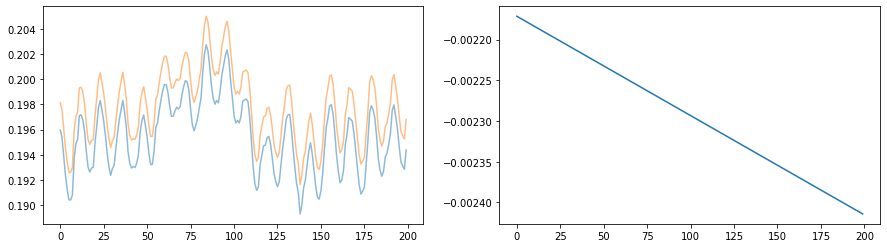

In [93]:
fig, ax = plt.subplots(1,2,figsize = (15, 4))
ax[0].plot(np.arange(len(orig_o2)), orig_o2, alpha = 0.5, label = 'original')
ax[0].plot(np.arange(len(detrnd_o2)), detrnd_o2, alpha = 0.5, label = 'detrended')

ax[1].plot(np.arange(len(orig_o2)), orig_o2 - detrnd_o2, label = 'recovered slope')

## Continue

In [15]:
#Implement combining grid labels step here when ready

In [96]:
#rechunk to make sure all chunks are even
for name, ds in ddict_detrended_filtered.items():
    if 'time' in ds.dims:
        ddict_detrended_filtered[name] = ds.chunk(chunks={'time':5})

In [97]:
ddict_detrended_filtered = filter_incomplete_members(ddict_detrended_filtered)

In [98]:
metric_vars = ['areacello', 'thkcello']

ddict_nested_ = merge_variables({name:ds for name, ds in ddict_detrended_filtered.items() if ds.attrs['variable_id'] not in metric_vars})
ddict_nested_metrics = merge_variables({name:ds for name, ds in ddict_detrended_filtered.items() if ds.attrs['variable_id'] in metric_vars})

ddict_nested = match_metrics(ddict_nested_, ddict_nested_metrics, ['areacello', 'thkcello'], exact_attrs = exact_attrs)

In [99]:
#this is just a check for the match_metrics
#Once I know it works, I can probably delete this cell
for name, ds in ddict_nested.items():
    for va in ['thkcello', 'areacello']:
        assert va in ds.variables
len(list(ddict_nested.keys()))

30

In [100]:
for name, ds in ddict_nested.items():
    ddict_nested[name] = ds.rename({'thkcello': 'dz_t'})

@@@@@@@@@@@@@@@@@
Processing CanESM5.gn.historical.Omon.r2i1p1f1
@@@@@@@@@@@@@@@@@
Writing to ../../data/processed/density_remapped_annual/CMIP.CCCma.CanESM5.historical.r2i1p1f1.Omon.gn.none_r2i1p1f1.nc
Replacing intake_esm_varname attrs value with `none`
masking all fields consistently
[########################################] | 100% Completed |  1min  2.7s
[########################################] | 100% Completed |  2min  3.1s


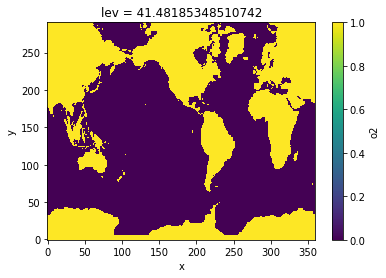

Remove bottom values
Remove ML
Check if ocean volume is conserved...
Relative difference ocean vol: 0.0009300246505793458% | OMZ vol [3.51057550e-06 1.96484217e-06 1.40375802e-06 9.58233898e-07
 6.59893001e-07 4.63015526e-07]%
@@@@@@@@@@@@@@@@@
Processing CanESM5.gn.historical.Omon.r17i1p1f1
@@@@@@@@@@@@@@@@@
Writing to ../../data/processed/density_remapped_annual/CMIP.CCCma.CanESM5.historical.r17i1p1f1.Omon.gn.none_r17i1p1f1.nc
Replacing intake_esm_varname attrs value with `none`
masking all fields consistently
[########################################] | 100% Completed |  1min  1.9s
[##                                      ] | 6% Completed | 23.5s


KeyboardInterrupt: 

In [101]:
#The final loop to vertically transform to sigma-space and save output

required_vars = ["thetao", "so", "o2", "dz_t"]#"areacello",

for name, ds in ddict_nested.items():
    #make sure all necessary data is present
    if missing_variables(ds, name, required_vars):
        continue
    
    else:    
        dataset_id = f"{cmip6_dataset_id(ds)}_{ds.attrs['variant_label']}"
        filename = ofolder.joinpath(f"{dataset_id}.nc")
        t0 = time.time()
        
        if file_exist_check(filename) and not overwrite:
            ds_sigma_reloaded = reload_preexisting(filename)
        else:
            print(f"Writing to {filename}")
            tempfilelist = []
            
            #plt.figure()
            #ds.isel(time=200, lev=10).thetao.plot()
            #plt.show()

            if ds.attrs["experiment_id"] == "piControl":
                ds = ds.isel(time=slice(-300 * 12, None))

            ds = preprocessing_wrapper(ds)
            
            #ds, tempfilelist = save_and_reload(ds, tempfolder)

            # I need to align.mask the thickness aswell!
            ds = ds.reset_coords(["dz_t"])
            ds["sigma_0"] = (fastjmd95.rho(ds.so, ds.thetao, 0) - 1000)
            
            #perform nan-masking functions
            print("masking all fields consistently")
            with ProgressBar():
                ds = align_missing(ds)
            print(f"Remove bottom values")
            ds = remove_bottom_values(ds)
            print(f"Remove ML")
            ds = mixed_layer_wrapper(ds)

            ds = ds.set_coords("dz_t")

            ds["omz_thickness"] = omz_thickness(
                ds, o2_bins=o2_bins
            )
            
            ds_sigma_monthly = transform_wrapper_again(ds)

            if vol_consistency_check_wrapper(ds, ds_sigma_monthly):
                continue
            else:
                ds_sigma_yearly = strip_encoding(resample_yearly(ds_sigma_monthly))
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")

                    ds_sigma_yearly, tempfilelist_var = temp_write_split(
                        ds_sigma_yearly,
                        tempfolder,
                        verbose=True,
                        method='dimension',
                        split_interval=3,
                    )
                    tempfilelist.extend(tempfilelist_var)

                # rechunk the resulting file for convenience
                ds_sigma_yearly = strip_encoding(
                    ds_sigma_yearly.chunk({"x": -1, "y": -1, "time": 2})
                )

                #################### write out results ########################
                with ProgressBar():
                    ds_sigma_reloaded = write(
                        ds_sigma_yearly,
                        filename,
                        overwrite=True,
                        force_load=False,
                        check_zarr_complete=True,
                    )
            ###### delete temps ######
            for tf in tempfilelist:
                if tf.exists():
                    shutil.rmtree(tf)
            ##################### Verification plotting ##########################
            try:
                plot_omz_results(ds_sigma_reloaded)
            except Exception as e:
                print(f"Plotting failed with: {e}")
        plt.show()
        t1 = time.time()
        print(f"Time passed: {(t1-t0)/60} minutes")